In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

data\human voice 1 to mr beast.mp3
data\human voice 1 to mr beast.wav
data\human voice 1.mp3
data\human voice 1.wav
data\human voice 2 to Jett.mp3
data\human voice 2.mp3
data\text to audio jett.mp3
data\text to audio jett.wav
data\DEMONSTRATION\DEMONSTRATION\linus-original-DEMO.mp3
data\DEMONSTRATION\DEMONSTRATION\linus-to-musk-DEMO.mp3
data\KAGGLE\DATASET-balanced.csv
data\KAGGLE\AUDIO\FAKE\biden-to-linus.wav
data\KAGGLE\AUDIO\FAKE\biden-to-margot.wav
data\KAGGLE\AUDIO\FAKE\biden-to-musk.wav
data\KAGGLE\AUDIO\FAKE\biden-to-Obama.wav
data\KAGGLE\AUDIO\FAKE\biden-to-ryan.wav
data\KAGGLE\AUDIO\FAKE\biden-to-taylor.wav
data\KAGGLE\AUDIO\FAKE\biden-to-Trump.wav
data\KAGGLE\AUDIO\FAKE\linus-to-biden.wav
data\KAGGLE\AUDIO\FAKE\linus-to-margot.wav
data\KAGGLE\AUDIO\FAKE\linus-to-musk.wav
data\KAGGLE\AUDIO\FAKE\linus-to-obama.wav
data\KAGGLE\AUDIO\FAKE\linus-to-ryan.wav
data\KAGGLE\AUDIO\FAKE\linus-to-taylor.wav
data\KAGGLE\AUDIO\FAKE\linus-to-trump.wav
data\KAGGLE\AUDIO\FAKE\margot-to-biden.w

# Import Libraries

In [2]:
%pip install resampy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Load Data

In [6]:
audio_files_path = "data\KAGGLE\AUDIO"

In [7]:
folders = os.listdir(audio_files_path)
print(folders)

['FAKE', 'REAL']


In [14]:
real_audio = "data\DEMONSTRATION\DEMONSTRATION\linus-original-DEMO.mp3"
fake_audio = "data\DEMONSTRATION\DEMONSTRATION\linus-to-musk-DEMO.mp3"

# Visualization

In [ ]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

# Load audio file
real_ad, real_sr = librosa.load(real_audio) 

# Create a figure for multiple subplots
fig, axes = plt.subplots(5, 1, figsize=(14, 25))  # 5 rows, 1 column

# 1. Real Audio Data Plot
axes[0].plot(real_ad)
axes[0].set_title("Real Audio Data")

# 2. Real Audio Spectrogram
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref=np.max)
img1 = librosa.display.specshow(real_spec, sr=real_sr, x_axis="time", y_axis="log", ax=axes[1])
axes[1].set_title("Real Audio Spectrogram")
fig.colorbar(img1, ax=axes[1], format="%+2.0f dB")

# 3. Real Audio Mel Spectrogram
real_mel_spect = librosa.feature.melspectrogram(y=real_ad, sr=real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref=np.max)
img2 = librosa.display.specshow(real_mel_spect, y_axis="mel", x_axis="time", ax=axes[2])
axes[2].set_title("Real Audio Mel Spectrogram")
fig.colorbar(img2, ax=axes[2], format="%+2.0f dB")

# 4. Real Audio Chromagram
real_chroma = librosa.feature.chroma_cqt(y=real_ad, sr=real_sr, bins_per_octave=36)
img3 = librosa.display.specshow(real_chroma, sr=real_sr, x_axis="time", y_axis="chroma", ax=axes[3], vmin=0, vmax=1)
axes[3].set_title("Real Audio Chromagram")
fig.colorbar(img3, ax=axes[3])

# 5. Real Audio MFCCs
real_mfccs = librosa.feature.mfcc(y=real_ad, sr=real_sr)
img4 = librosa.display.specshow(real_mfccs, sr=real_sr, x_axis="time", ax=axes[4])
axes[4].set_title("Real Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
fig.colorbar(img4, ax=axes[4])

# Adjust layout and save the image
plt.tight_layout()
plt.savefig('combined_audio_visualizations.png', bbox_inches='tight')
plt.close(fig)  # Close the figure to prevent it from displaying in the notebook

print("All visualizations saved as 'combined_audio_visualizations.png'")


All visualizations saved as 'combined_audio_visualizations.png'


In [21]:
fake_ad, fake_sr = librosa.load(fake_audio)  # Replace with your actual file path

# Create a figure for multiple subplots
fig, axes = plt.subplots(5, 1, figsize=(14, 25))  # 5 rows, 1 column

# 1. Fake Audio Data Plot
axes[0].plot(fake_ad)
axes[0].set_title("Fake Audio Data")

# 2. Fake Audio Spectrogram
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref=np.max)
img1 = librosa.display.specshow(fake_spec, sr=fake_sr, x_axis="time", y_axis="log", ax=axes[1])
axes[1].set_title("Fake Audio Spectrogram")
fig.colorbar(img1, ax=axes[1], format="%+2.0f dB")

# 3. Fake Audio Mel Spectrogram
fake_mel_spect = librosa.feature.melspectrogram(y=fake_ad, sr=fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref=np.max)
img2 = librosa.display.specshow(fake_mel_spect, y_axis="mel", x_axis="time", ax=axes[2])
axes[2].set_title("Fake Audio Mel Spectrogram")
fig.colorbar(img2, ax=axes[2], format="%+2.0f dB")

# 4. Fake Audio Chromagram
fake_chroma = librosa.feature.chroma_cqt(y=fake_ad, sr=fake_sr, bins_per_octave=36)
img3 = librosa.display.specshow(fake_chroma, sr=fake_sr, x_axis="time", y_axis="chroma", ax=axes[3], vmin=0, vmax=1)
axes[3].set_title("Fake Audio Chromagram")
fig.colorbar(img3, ax=axes[3])

# 5. Fake Audio MFCCs
fake_mfccs = librosa.feature.mfcc(y=fake_ad, sr=fake_sr)
img4 = librosa.display.specshow(fake_mfccs, sr=fake_sr, x_axis="time", ax=axes[4])
axes[4].set_title("Fake Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
fig.colorbar(img4, ax=axes[4])

# Adjust layout and save the image
plt.tight_layout()
plt.savefig('combined_fake_audio_visualizations.png', bbox_inches='tight')
plt.close(fig)  # Close the figure to prevent it from displaying in the notebook

print("Fake audio visualizations saved as 'combined_fake_audio_visualizations.png'")


Fake audio visualizations saved as 'combined_fake_audio_visualizations.png'


# Preprocess

In [22]:
data = []
labels = []

for folder in folders:
    files = os.listdir(os.path.join(audio_files_path, folder))
    for file in tqdm(files):
        file_path = os.path.join(audio_files_path, folder, file)
        audio, sample_rate = librosa.load(file_path, res_type="kaiser_fast")
        mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_features_scaled = np.mean(mfccs_features.T, axis=0)
        data.append(mfccs_features_scaled)
        labels.append(folder)

100%|██████████| 8/8 [00:47<00:00,  5.96s/it]


In [83]:
feature_df = pd.DataFrame({"features": data, "class": labels})
feature_df.head()

,features,class
0,"[-260.1085, 100.856926, -25.453163, -0.2690358...",FAKE
1,"[-258.9036, 93.914345, -27.627075, -1.9326234,...",FAKE
2,"[-268.50894, 118.533066, -38.89298, 13.812951,...",FAKE
3,"[-272.68378, 101.50515, -22.251564, 4.101077, ...",FAKE
4,"[-254.73932, 66.81036, -33.19487, -4.094302, -...",FAKE


In [84]:
feature_df["class"].value_counts()

class
FAKE    56
REAL     8
Name: count, dtype: int64

In [85]:
def label_encoder(column):
    le = LabelEncoder().fit(column)
    print(column.name, le.classes_)
    return le.transform(column)

In [86]:
feature_df["class"] = label_encoder(feature_df["class"])

class ['FAKE' 'REAL']


In [88]:
# Convert the data and labels into a DataFrame
df = pd.DataFrame(data)
df['Label'] = labels  # Add the labels as a new column

# Export the DataFrame to a CSV file
df.to_csv('audio_features_labels.csv', index=False)

print("Data and labels have been exported to 'audio_features_labels.csv'.")


Data and labels have been exported to 'audio_features_labels.csv'.


# Feature Scaling

In [89]:
X = np.array(feature_df["features"].tolist())
y = np.array(feature_df["class"].tolist())

In [90]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [91]:
y_resampled = to_categorical(y_resampled)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [93]:
num_labels = len(feature_df["class"].unique())
num_labels

2

In [94]:
input_shape = feature_df["features"][0].shape
input_shape

(40,)

# Model

In [95]:
model = Sequential()
model.add(Dense(128, input_shape=input_shape))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_labels))
model.add(Activation(activation="softmax"))

In [96]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [97]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               5248      
                                                                 
 activation_4 (Activation)   (None, 128)               0         
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 activation_5 (Activation)   (None, 256)               0         
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [132]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=2, epochs=100)

Epoch 1/100
45/45 [==============================] - 0s 7ms/step - loss: 0.1545 - accuracy: 0.9551 - val_loss: 0.2482 - val_accuracy: 0.9130
Epoch 2/100
45/45 [==============================] - 0s 4ms/step - loss: 0.2620 - accuracy: 0.8652 - val_loss: 0.1739 - val_accuracy: 1.0000
Epoch 3/100
45/45 [==============================] - 0s 5ms/step - loss: 0.1640 - accuracy: 0.8989 - val_loss: 0.3097 - val_accuracy: 0.8696
Epoch 4/100
45/45 [==============================] - 0s 4ms/step - loss: 0.2892 - accuracy: 0.8876 - val_loss: 0.1763 - val_accuracy: 0.9130
Epoch 5/100
45/45 [==============================] - 0s 4ms/step - loss: 0.2386 - accuracy: 0.9213 - val_loss: 0.2155 - val_accuracy: 0.9130
Epoch 6/100
45/45 [==============================] - 0s 4ms/step - loss: 0.1840 - accuracy: 0.9663 - val_loss: 0.1757 - val_accuracy: 0.9565
Epoch 7/100
45/45 [==============================] - 0s 4ms/step - loss: 0.3912 - accuracy: 0.8764 - val_loss: 0.2551 - val_accuracy: 0.8696
Epoch 8/100
4

In [133]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

1/1 [==============================] - 0s 26ms/step - loss: 0.3522 - accuracy: 0.9130
Test Loss: 0.35215792059898376
Test Accuracy: 0.9130434989929199


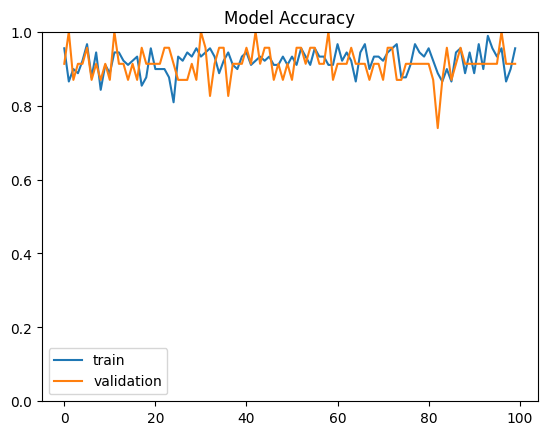

In [134]:
plt.figure()
plt.title("Model Accuracy")
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

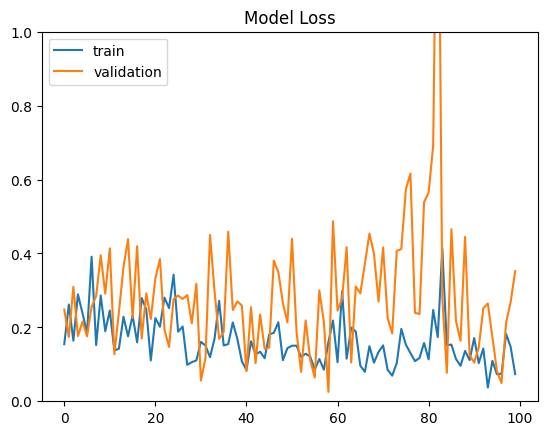

In [135]:
plt.figure()
plt.title("Model Loss")
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

# Test

In [102]:
def detect_fake(filename):
    sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")
    mfcc_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
    mfccs_features_scaled = np.mean(mfcc_features.T, axis=0)
    mfccs_features_scaled = mfccs_features_scaled.reshape(1, -1)
    result_array = model.predict(mfccs_features_scaled)
    print(result_array)
    result_classes = ["FAKE", "REAL"]
    result = np.argmax(result_array[0])
    print("Result:", result_classes[result])

In [129]:
test_real = r"data\real life test audio\human voice 1.mp3"
test_fake = r"data\real life test audio\human voice 1 to mr beast.mp3"

In [130]:
detect_fake(test_real)

1/1 [==============================] - 0s 27ms/step
[[0.86957264 0.13042735]]
Result: FAKE


In [131]:
detect_fake(test_fake)

1/1 [==============================] - 0s 18ms/step
[[0.90067667 0.09932333]]
Result: FAKE
